In [1]:
# Cell 1: Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from imblearn.over_sampling import SMOTE
import pickle
import mlflow
import mlflow.sklearn
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
# Cell 2: Load and prepare the dataset
# Load data
df = pd.read_csv("Student_survey.csv")

# Rename target column
df = df.rename(columns={"Affects_Academic_Performance": "Affects"})

# Drop rows with missing target
df = df[df["Affects"].notna()]

# Convert Yes/No to 1/0
df["Affects"] = df["Affects"].map({"Yes": 1, "No": 0})

# Display first few rows
print("First few rows of the dataset:")
display(df.head())

# Check class distribution
print("\nClass distribution:")
print(df["Affects"].value_counts(normalize=True))

First few rows of the dataset:


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,1,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,0,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,1,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,0,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,1,6.0,6,In Relationship,2,7



Class distribution:
Affects
1    0.642553
0    0.357447
Name: proportion, dtype: float64


In [3]:
# Cell 3: Feature Engineering
# Create interaction features
df['Sleep_Usage_Interaction'] = df['Sleep_Hours_Per_Night'] * df['Avg_Daily_Usage_Hours']
df['Mental_Usage_Interaction'] = df['Mental_Health_Score'] * df['Avg_Daily_Usage_Hours']

# Bin continuous variables
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df[['Age_Binned', 'Usage_Binned', 'Sleep_Binned']] = discretizer.fit_transform(
    df[['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night']]
)

# Display the new features
print("New engineered features:")
display(df[['Sleep_Usage_Interaction', 'Mental_Usage_Interaction', 
            'Age_Binned', 'Usage_Binned', 'Sleep_Binned']].head())

New engineered features:


,Sleep_Usage_Interaction,Mental_Usage_Interaction,Age_Binned,Usage_Binned,Sleep_Binned
0,33.80,31.2,1.0,3.0,1.0
1,15.75,16.8,4.0,0.0,3.0
2,30.00,30.0,2.0,3.0,0.0
3,21.00,21.0,0.0,0.0,2.0
4,27.00,27.0,3.0,2.0,1.0


In [4]:
# Cell 4: Prepare features and target
features = [
    "Age", "Gender", "Academic_Level", "Country",
    "Avg_Daily_Usage_Hours", "Most_Used_Platform",
    "Sleep_Hours_Per_Night", "Mental_Health_Score",
    "Sleep_Usage_Interaction", "Mental_Usage_Interaction",
    "Age_Binned", "Usage_Binned", "Sleep_Binned"
]

X = df[features]
y = df["Affects"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (705, 13)
Target shape: (705,)


In [5]:
# Cell 5: Preprocess data
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=["Gender", "Academic_Level", "Country", "Most_Used_Platform"], 
                         drop_first=False)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
num_cols = ["Age", "Avg_Daily_Usage_Hours", "Sleep_Hours_Per_Night", "Mental_Health_Score",
            "Sleep_Usage_Interaction", "Mental_Usage_Interaction"]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Training set shape after SMOTE:", X_train_resampled.shape)
print("Test set shape:", X_test_scaled.shape)

Training set shape after SMOTE: (724, 136)
Test set shape: (141, 136)


In [6]:
# Cell 6: Train and evaluate model
# Initialize model with balanced parameters
model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("CV score std:", cv_scores.std())

# Train on full training set
model.fit(X_train_resampled, y_train_resampled)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_resampled.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Make predictions
y_pred = model.predict(X_test_scaled)

# Print classification report
print("\nTest set metrics:")
print(classification_report(y_test, y_pred))

Cross-validation scores: [1.         0.9862069  0.97241379 0.9862069  0.95833333]
Mean CV score: 0.9806321839080459
CV score std: 0.014156608539204443

Top 10 most important features:
                         feature  importance
3            Mental_Health_Score    0.283631
1          Avg_Daily_Usage_Hours    0.176983
2          Sleep_Hours_Per_Night    0.107945
8                   Sleep_Binned    0.058507
4        Sleep_Usage_Interaction    0.052361
7                   Usage_Binned    0.052238
130    Most_Used_Platform_TikTok    0.035193
5       Mental_Usage_Interaction    0.031118
124  Most_Used_Platform_Facebook    0.021960
56               Country_Ireland    0.021721

Test set metrics:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        50
           1       1.00      0.95      0.97        91

    accuracy                           0.96       141
   macro avg       0.95      0.97      0.96       141
weighted avg       0.97      0

Training Set Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       362
           1       1.00      0.99      1.00       362

    accuracy                           1.00       724
   macro avg       1.00      1.00      1.00       724
weighted avg       1.00      1.00      1.00       724


Test Set Metrics:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        50
           1       1.00      0.95      0.97        91

    accuracy                           0.96       141
   macro avg       0.95      0.97      0.96       141
weighted avg       0.97      0.96      0.96       141



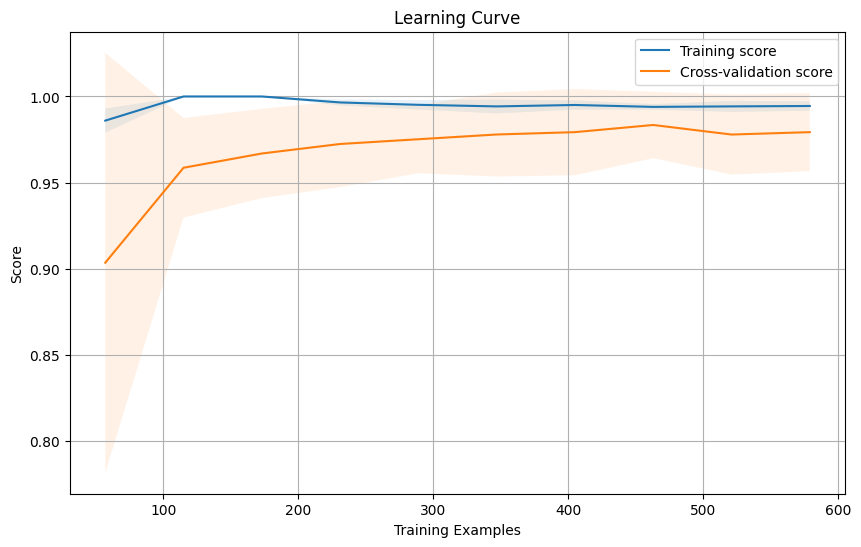

In [7]:
# Cell 7: Overfitting Analysis - Part 1
# Compare training and test set performance
y_train_pred = model.predict(X_train_resampled)
y_test_pred = model.predict(X_test_scaled)

print("Training Set Metrics:")
print(classification_report(y_train_resampled, y_train_pred))
print("\nTest Set Metrics:")
print(classification_report(y_test, y_test_pred))

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, 
    X_train_resampled, 
    y_train_resampled,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Calculate mean and std for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

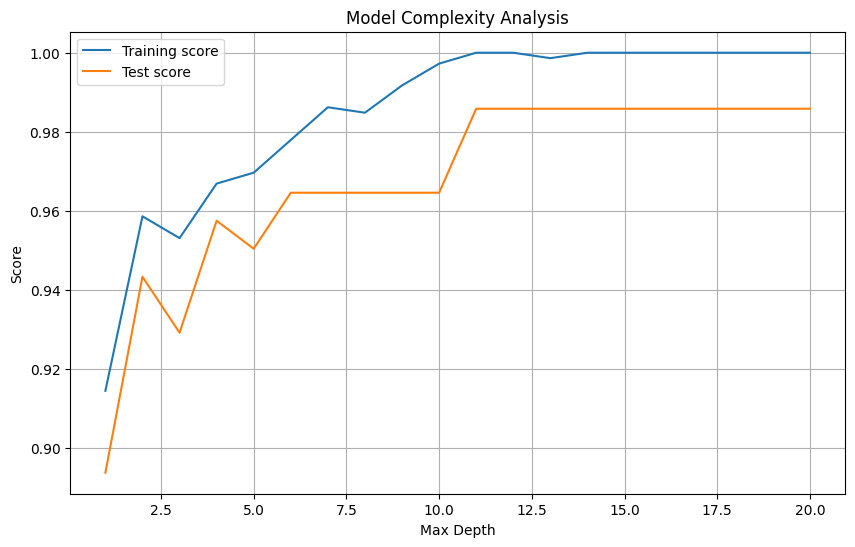

In [8]:
# Cell 8: Overfitting Analysis - Part 2
# Model Complexity Analysis
max_depths = range(1, 21)
train_scores = []
test_scores = []

for depth in max_depths:
    model = RandomForestClassifier(
        n_estimators=50,
        max_depth=depth,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train_resampled, y_train_resampled)
    train_scores.append(model.score(X_train_resampled, y_train_resampled))
    test_scores.append(model.score(X_test_scaled, y_test))

# Plot complexity curve
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, label='Training score')
plt.plot(max_depths, test_scores, label='Test score')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Model Complexity Analysis')
plt.legend(loc='best')
plt.grid(True)
plt.show()

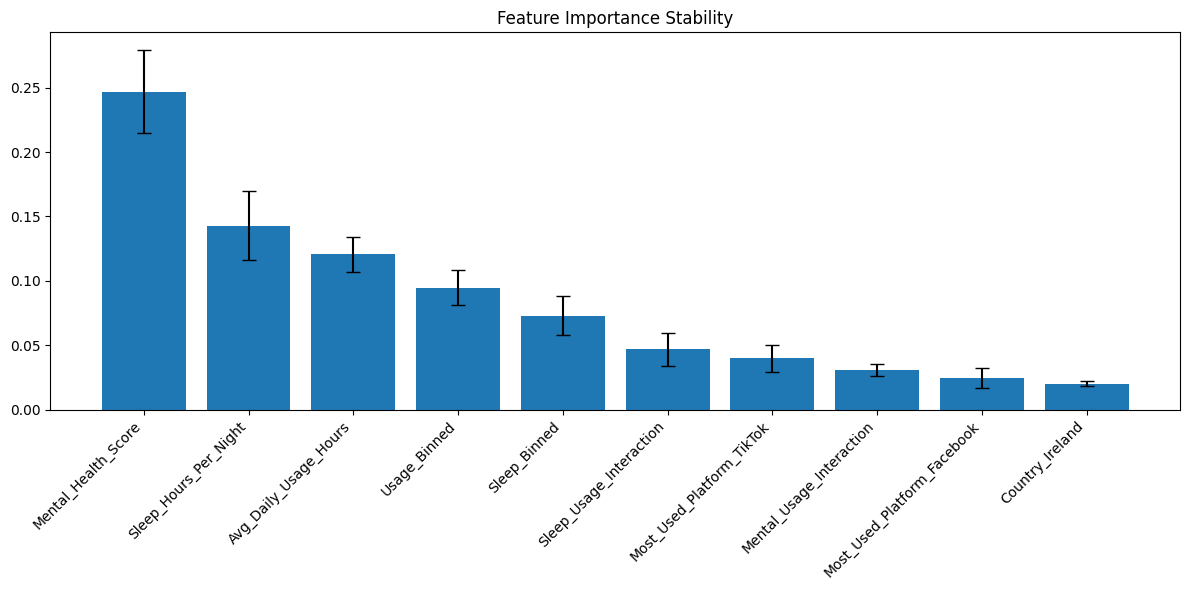


Feature Importance Stability Summary:
                                 mean       std
Mental_Health_Score          0.246773  0.032233
Sleep_Hours_Per_Night        0.142933  0.026786
Avg_Daily_Usage_Hours        0.120515  0.013512
Usage_Binned                 0.094749  0.013883
Sleep_Binned                 0.072944  0.015229
Sleep_Usage_Interaction      0.046737  0.012588
Most_Used_Platform_TikTok    0.039851  0.010648
Mental_Usage_Interaction     0.030910  0.004648
Most_Used_Platform_Facebook  0.024428  0.007535
Country_Ireland              0.020224  0.001806


In [9]:
# Cell 9: Overfitting Analysis - Part 3
# Feature Importance Stability
feature_importance_stability = pd.DataFrame(index=X_train_resampled.columns)

for i in range(5):
    model = RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced',
        random_state=i
    )
    model.fit(X_train_resampled, y_train_resampled)
    feature_importance_stability[f'run_{i}'] = model.feature_importances_

# Calculate mean and std of feature importance
feature_importance_stability['mean'] = feature_importance_stability.mean(axis=1)
feature_importance_stability['std'] = feature_importance_stability.std(axis=1)

# Plot feature importance stability
plt.figure(figsize=(12, 6))
top_features = feature_importance_stability.nlargest(10, 'mean')
plt.bar(range(len(top_features)), top_features['mean'])
plt.errorbar(range(len(top_features)), top_features['mean'], 
             yerr=top_features['std'], fmt='none', color='black', capsize=5)
plt.xticks(range(len(top_features)), top_features.index, rotation=45, ha='right')
plt.title('Feature Importance Stability')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nFeature Importance Stability Summary:")
print(feature_importance_stability.nlargest(10, 'mean')[['mean', 'std']])

In [10]:
# Cell 10: Save model and results
# Save model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully!")

# Optional: MLflow tracking
mlflow.set_experiment("SocialMedia_AcademicImpact")

with mlflow.start_run():
    # Log parameters
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 50)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("min_samples_split", 5)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("precision", precision_score(y_test, y_pred))
    mlflow.log_metric("recall", recall_score(y_test, y_pred))
    mlflow.log_metric("cv_mean", cv_scores.mean())
    mlflow.log_metric("cv_std", cv_scores.std())
    
    # Log model and artifacts
    mlflow.sklearn.log_model(model, "model")
    mlflow.log_artifact("model.pkl")
    mlflow.log_artifact("scaler.pkl")

print("MLflow tracking completed!")

Model and scaler saved successfully!


2025/05/31 17:29:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow tracking completed!
